## Fitting models, testing models, plotting results

The data loaded into this notebook has been scaled where apporpriate (some dummy columns were left unscaled).  

Below there will be some feature engineering that I will outline.

In [1]:
#read in appropriate libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 2100)

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
train = pd.read_csv('./datasets/scale_reg_train.csv')

## Features

I spent a lot of time checking feature correlation with the target variable, as well as glancing at the p-value for various features.  After a lot of experimenting, these were the features I decided to use going forward in this notebook.

In [5]:
#lists of features where null hypothesis could not be ruled out

features = ['overall_qual',
            'exter_qual',
            'gr_liv_area',
            'garage_area',
            'total_bsmt_sf',
            '1st_flr_sf',
            'bsmt_qual',
            'mas_vnr_area',
            'remod_after_1993',
            'heating_qc',
            'neighborhood_NridgHt',
            'bsmt_exposure',
            'bsmtfin_sf_1',
            'mas_vnr_type',
            'exterior_1st_VinylSd',
            'wood_deck_sf',
            'lot_frontage',
            'neighborhood_OldTown',
            'roof_style',
            'lot_area',
            '2nd_flr_sf']


              


## Interaction terms

Below I make four new columns by multiplying existing columns together to come up with interaction terms.

In [6]:
train['over_exter'] = train.overall_qual * train.exter_qual
train['above_below_sf'] = train.total_bsmt_sf * train.gr_liv_area
train['1st_2nd_sf'] = train['1st_flr_sf'] * train['2nd_flr_sf']
train['lot_front_area'] = train.lot_area * train.lot_frontage

In [7]:
inter_terms = ['over_exter', 'above_below_sf', '1st_2nd_sf', 'lot_front_area']

In [8]:
#add the new columns to the existing feature columns

for i in inter_terms:
    features.append(i)

## Polynomial features

I chose the following four columns to make into polynomial features.  Much like with the interaction terms, a concern for multicollinearity is why I chose to do feature engineering on these specific features.

In [9]:
features_2 = ['gr_liv_area',
            'garage_area',
            'total_bsmt_sf',
            '1st_flr_sf',
            'bsmtfin_sf_1',]
          

In [10]:
p_feat = train[features_2]

In [11]:
#this will just create a numpy array

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(p_feat)

In [12]:
#this will provide me with column names so that I can put the new data back
#into a pandas dataframe

poly_col_names = poly.get_feature_names(features_2)
poly_col_names

['gr_liv_area',
 'garage_area',
 'total_bsmt_sf',
 '1st_flr_sf',
 'bsmtfin_sf_1',
 'gr_liv_area^2',
 'gr_liv_area garage_area',
 'gr_liv_area total_bsmt_sf',
 'gr_liv_area 1st_flr_sf',
 'gr_liv_area bsmtfin_sf_1',
 'garage_area^2',
 'garage_area total_bsmt_sf',
 'garage_area 1st_flr_sf',
 'garage_area bsmtfin_sf_1',
 'total_bsmt_sf^2',
 'total_bsmt_sf 1st_flr_sf',
 'total_bsmt_sf bsmtfin_sf_1',
 '1st_flr_sf^2',
 '1st_flr_sf bsmtfin_sf_1',
 'bsmtfin_sf_1^2']

In [13]:
poly_list = ['overall_qual',
             'exter_qual',
             'bsmt_qual',
             'fireplace_qu',
             'mas_vnr_area',
             'remod_after_1993',
             'fireplaces',
             'heating_qc',
             'neighborhood_NridgHt',
             'bsmt_exposure',
             'mas_vnr_type',
             'garage_type',
             'exterior_1st_VinylSd',
             'open_porch_sf',
             'wood_deck_sf',
             'lot_frontage',
             'neighborhood_OldTown',
             'roof_style',
             'lot_shape',
             'foundation_CBlock',
             'lot_area',
             '2nd_flr_sf']

In [14]:
#putting the polynomial features into a dataframe
poly_train_df = pd.DataFrame(X_poly, columns=poly_col_names)

In [15]:
#creating the new X and y variables from the engineered features
X_poly_train = pd.concat([train[poly_list], poly_train_df], axis=1)
y_poly_train = train.saleprice

## Modeling

Now that I have done some feature engineering on both the kaggle training data and the kaggle test data, I can do a train test split on the training data 

In [16]:
#i'll start with the features that include the interaction terms

X = train[features]
y = train.saleprice

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [18]:
#instantiate a linear regression model

lr = LinearRegression()
cross_val_score(lr, X_train, y_train_log, cv=5).mean()

0.8640471888966106

In [19]:
#fit the model
model = lr.fit(X_train, y_train_log)
#score on training set
model.score(X_train, y_train_log)

0.8834320361251877

In [20]:
#score on test set
model.score(X_test, y_test_log)

0.8646863288620932

In [21]:
#check the root mean squared error
lr_preds_1 = model.predict(X_test)

#convert back from log value to regular value so that it can be compared with
#original y_test values in order to get the root mean squared error
lr_preds_1 = np.exp(lr_preds_1)
lr_rmse_1 = (mean_squared_error(y_test, lr_preds_1) ** .5).round(2)
lr_rmse_1

24619.53

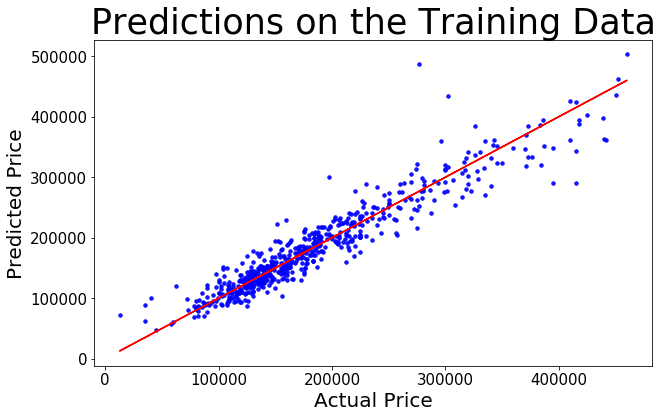

In [22]:
#visualize the predictions versus the actual values
plt.figure(figsize=(10, 6))

#scatter plot of true y value vs predicted
plt.scatter(y_test, lr_preds_1, c='b', s=12, alpha = .9)

#plot the line going through the true y values
plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [23]:
#now I'll model with the polynomial features

X_train, X_test, y_train, y_test = train_test_split(X_poly_train,
                                                    y_poly_train,
                                                    test_size=.3,
                                                    random_state=42)

In [24]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [25]:
lr = LinearRegression()
cross_val_score(lr, X_train, y_train_log, cv=5).mean()

0.872966636787371

In [26]:
model = lr.fit(X_train, y_train_log)

model.score(X_train, y_train_log)

0.8909479213174517

In [27]:
model.score(X_test, y_test_log)

0.8689279957148585

In [28]:
#check the root mean squared error
lr_preds_2 = model.predict(X_test)

#convert back from log value to regular value so that it can be compared with
#original y_test values in order to get the root mean squared error
lr_preds_2 = np.exp(lr_preds_2)
lr_rmse_2 = (mean_squared_error(y_test, lr_preds_2) ** .5).round(2)
lr_rmse_2

23683.22

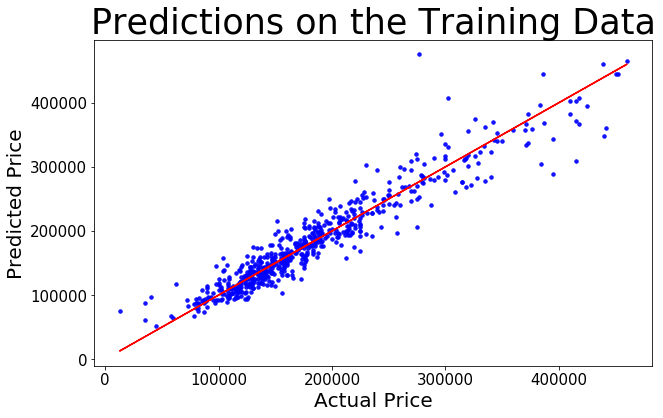

In [29]:
#visualize the predictions versus the actual values
plt.figure(figsize=(10, 6))

#scatter plot of true y value vs predicted
plt.scatter(y_test, lr_preds_2, c='b', s=12, alpha = .9)

#plot the line going through the true y values
plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Model with Lasso Regularization

In [30]:
#lasso with interaction terms

X = train[features]
y = train.saleprice

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [32]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [33]:
lasso = LassoCV(cv=5)

cross_val_score(lasso, X_train, y_train_log, cv=5).mean()

0.8640775969549361

In [34]:
lasso_model = lasso.fit(X_train, y_train_log)
lasso_model.score(X_train, y_train_log)

0.8818699375561588

In [35]:
lasso_model.score(X_test, y_test_log)

0.864514870532844

In [36]:
lasso_preds_1 = lasso_model.predict(X_test)
lasso_preds_1 = np.exp(lasso_preds_1)

In [37]:
lasso_rmse_1 = (mean_squared_error(y_test, lasso_preds_1) ** .5).round(2)
lasso_rmse_1

24361.03

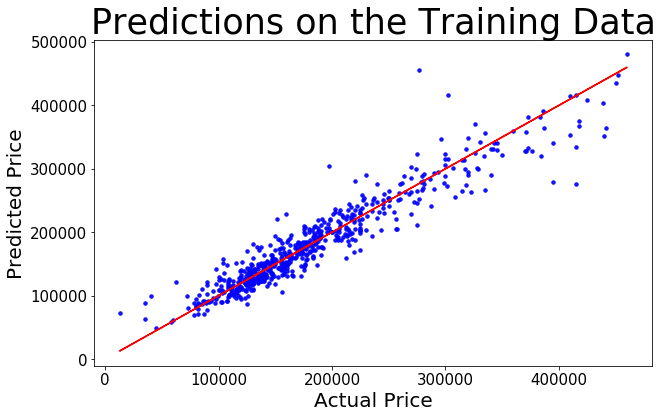

In [38]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, lasso_preds_1, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [39]:
#lasso with polynomial features
X_train, X_test, y_train, y_test = train_test_split(X_poly_train,
                                                    y_poly_train,
                                                    test_size=.3,
                                                    random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [40]:
lasso = LassoCV(cv=5, max_iter=5000)

cross_val_score(lasso, X_train, y_train_log, cv=5).mean()

0.8760174000320132

In [41]:
lasso_model = lasso.fit(X_train, y_train_log)
lasso_model.score(X_train, y_train_log)

0.8894576418610708

In [42]:
lasso_model.score(X_test, y_test_log)

0.8665920993606355

In [43]:
lasso_preds_2 = lasso_model.predict(X_test)
lasso_preds_2 = np.exp(lasso_preds_2)

lasso_rmse_2 = (mean_squared_error(y_test, lasso_preds_2) ** .5).round(2)
lasso_rmse_2

23750.02

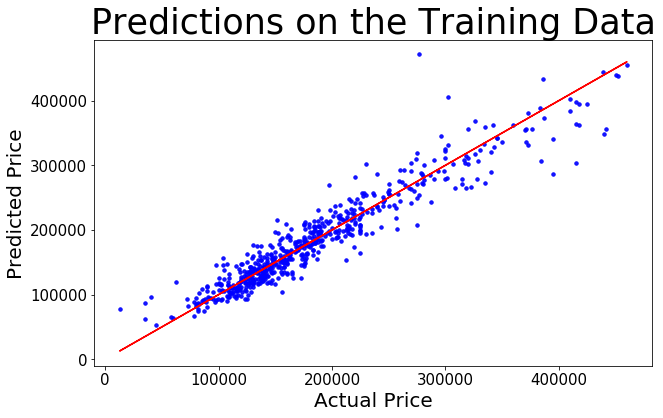

In [44]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, lasso_preds_2, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Model with Ridge Regularization

In [45]:
# ridge with interaction terms
X = train[features]
y = train.saleprice

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [47]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [48]:
ridge = RidgeCV()
cross_val_score(ridge, X_train, y_train_log, cv=5).mean()

0.8736734553638191

In [49]:
ridge_model = ridge.fit(X_train, y_train_log)

ridge_model.score(X_train, y_train_log)

0.8843130216012851

In [50]:
ridge_model.score(X_test, y_test_log)

0.854660910889951

In [51]:
ridge_preds_1 = ridge_model.predict(X_test)
ridge_preds_1 = np.exp(ridge_preds_1)

In [52]:
ridge_rmse_1 = (mean_squared_error(y_test, ridge_preds_1) ** .5).round(2)
ridge_rmse_1

25598.88

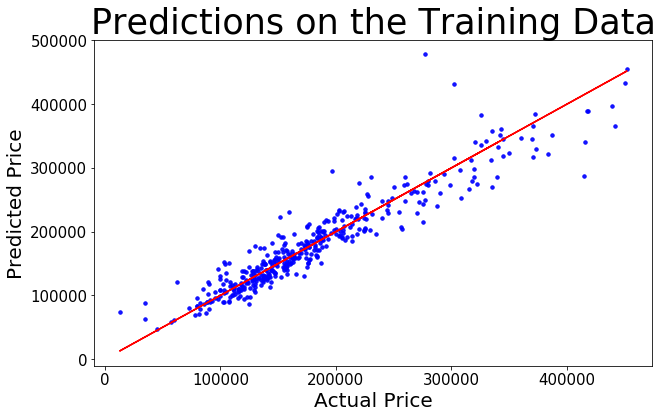

In [53]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, ridge_preds_1, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [54]:
#ridge with polynomial features
X_train, X_test, y_train, y_test = train_test_split(X_poly_train,
                                                    y_poly_train,
                                                    test_size=.3,
                                                    random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [55]:
ridge = RidgeCV(cv=5)

cross_val_score(ridge, X_train, y_train_log, cv=5).mean()

0.8751198789935832

In [56]:
ridge_model = ridge.fit(X_train, y_train_log)
ridge_model.score(X_train, y_train_log)

0.890889224134676

In [57]:
ridge_model.score(X_test, y_test_log)

0.8686320440996305

In [58]:
ridge_preds_2 = ridge_model.predict(X_test)
ridge_preds_2 = np.exp(ridge_preds_2)

ridge_rmse_2 = (mean_squared_error(y_test, ridge_preds_2) ** .5).round(2)
ridge_rmse_2

23609.82

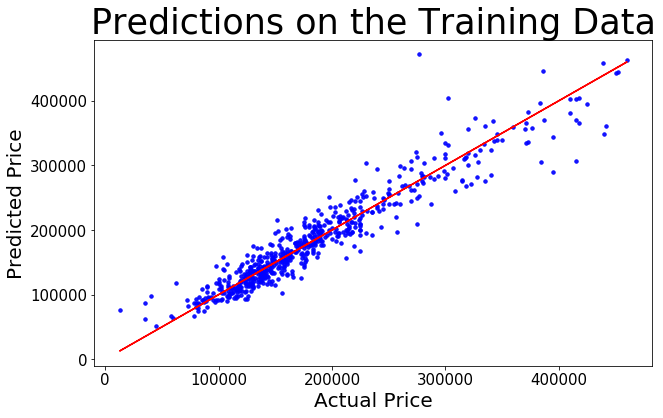

In [59]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, ridge_preds_2, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Model with Elastic Net

In [60]:
X = train[features]
y = train.saleprice

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=42)

In [62]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [63]:
enet = ElasticNetCV(cv=5)
cross_val_score(enet, X_train, y_train_log, cv=5).mean()

0.864114852940338

In [64]:
enet_model = enet.fit(X_train, y_train_log)
enet_model.score(X_train, y_train_log)

0.8819367850141671

In [65]:
enet_model.score(X_test, y_test_log)

0.8645052220270277

In [66]:
enet_preds_1 = enet.predict(X_test)
enet_preds_1 = np.exp(enet_preds_1)

In [67]:
enet_rmse_1 = (mean_squared_error(y_test, enet_preds_1) ** .5).round(2)
enet_rmse_1

24366.78

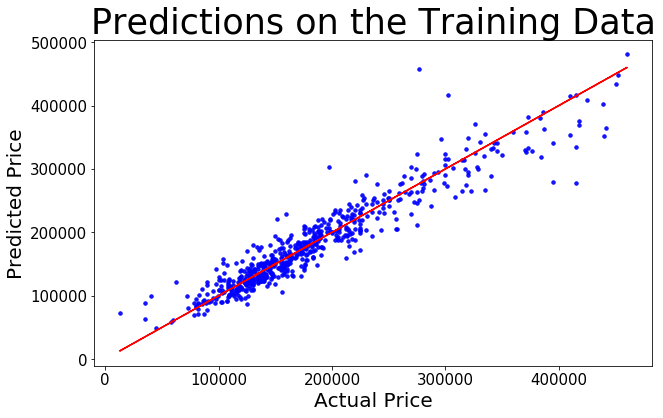

In [68]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, enet_preds_1, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)

plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [69]:
#elastic net with polynomial features
X_train, X_test, y_train, y_test = train_test_split(X_poly_train,
                                                    y_poly_train,
                                                    test_size=.3,
                                                    random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [70]:
enet = ElasticNetCV(cv=5, max_iter=5000)

cross_val_score(enet, X_train, y_train_log, cv=5).mean()

0.875785524715744

In [71]:
enet_model = enet.fit(X_train, y_train_log)
enet_model.score(X_train, y_train_log)

0.8894153558316275

In [72]:
enet_model.score(X_test, y_test_log)

0.8665362982469127

In [73]:
enet_preds_2 = enet_model.predict(X_test)
enet_preds_2 = np.exp(enet_preds_2)

enet_rmse_2 = (mean_squared_error(y_test, enet_preds_2) ** .5).round(2)
enet_rmse_2

23734.51

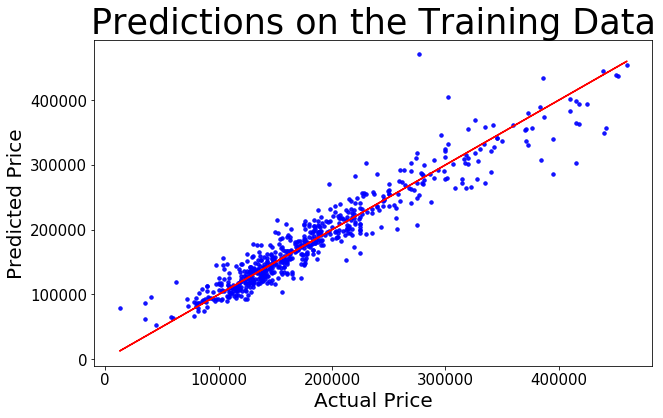

In [74]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, enet_preds_2, c='b', s=12, alpha = .9)

plt.plot(y_test, y_test, c='r')

plt.title('Predictions on the Training Data',
         fontsize=35)
plt.ylabel('Predicted Price', fontsize=20)
plt.xlabel('Actual Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Comparing the loss amongst the four different models

In [75]:
#first with the interaction terms

loss = pd.DataFrame(columns=['regularization', 'rmse'])

a = ['none', 'lasso', 'ridge', 'elastic_net']

b = [lr_rmse_1, lasso_rmse_1, ridge_rmse_1, enet_rmse_1]

loss['regularization'] = a
loss['rmse'] = b

loss.round(2)

loss

,regularization,rmse
0,none,24619.53
1,lasso,24361.03
2,ridge,25598.88
3,elastic_net,24366.78


In [76]:
#first with the interaction terms

loss_2 = pd.DataFrame(columns=['regularization', 'rmse'])

a = ['none', 'lasso', 'ridge', 'elastic_net']

b = [lr_rmse_2, lasso_rmse_2, ridge_rmse_2, enet_rmse_2]

loss_2['regularization'] = a
loss_2['rmse'] = b

loss_2.round(2)

loss_2

,regularization,rmse
0,none,23683.22
1,lasso,23750.02
2,ridge,23609.82
3,elastic_net,23734.51
